In [1]:
# # # for imagenet
# # INPUT_SHAPE = (224, 224, 3)
# # image_size = 224
# # CATGORICAL = 2
# # LR=1e-3

# # for cifar
# INPUT_SHAPE = (32, 32, 3)
# image_size = 32
# CATGORICAL = 10
# LR=1e-2

# BATCH_SIZE = 128 
# EPOCHS = 100
# PATIENCE = 20 #果過多少個EPOCHS沒改善就停止訓練

# LR_FACTOR = 0.5 # new_lr = lr * factor.
# LR_PATIENCE = 10 #number of epochs with no improvement after which learning rate will be reduced
# MODEL_NAME = 'ResNet50_cup04'
# MODEL_PATH = MODEL_NAME + '.hdf5'

In [2]:
import numpy as np
x_train = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/x_train_cifar10_unlearn.npy')
y_train = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/y_train_cifar10.npy')
x_val = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/x_val_cifar10.npy')
y_val = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/y_val_cifar10.npy')
x_test = np.load('./datalab-cup4-unlearnable-datasets-cifar-10/x_test_cifar10.npy')
# y_train = np.argmax(y_train, axis=1)
# y_val = np.argmax(y_val, axis=1)

y_val

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, ReLU, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
BATCH_SIZE = 128
batched_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 10)
    .batch(BATCH_SIZE)
)
batched_val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential


In [8]:
class AE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same')
        self.BN1 = BatchNormalization()
        self.relu = Activation('relu')
        self.maxpool = MaxPooling2D((2, 2), padding='same')
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.BN2 = BatchNormalization()
        
        self.conv3 = Conv2D(32, (3, 3), padding='same')
        self.conv4 = Conv2D(32, (3, 3), padding='same')
        self.conv5 = Conv2D(3, (3, 3), padding='same')
        self.upsample = UpSampling2D((2, 2))
        self.sigmoid = Activation('sigmoid')
        self.BN3 = BatchNormalization()
        self.BN4 = BatchNormalization()
        self.BN5 = BatchNormalization()
        
    def encode(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
        
    def decode(self, x):
        x = self.conv3(x)
        x = self.BN3(x)
        x = self.relu(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.BN4(x)
        x = self.relu(x)
        x = self.upsample(x)
        x = self.conv5(x)
        x = self.BN5(x)
        x = self.sigmoid(x)
        return x
        
    def call(self, inputs):
        x = self.encode(inputs)
        x = self.decode(x)
        return x
        

In [9]:
# input_img = Input(shape=(32, 32, 3))
# x = Conv2D(32, (3, 3), padding='same')(input_img)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# encoded = MaxPooling2D((2, 2), padding='same',name='encoder_output')(x)

# x = Conv2D(32, (3, 3), padding='same')(encoded)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(3, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# decoded = Activation('sigmoid')(x)

In [10]:
# model = Model(input_img, decoded)
autoencoder = AE()
# input_img = Input(shape=(32, 32, 3))
autoencoder.build((None, 32, 32, 3))
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# model.summary()

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 30,031
Trainable params: 29,769
Non-trainable params: 262
_________________________________________________________________


In [11]:
# es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# chkpt = 'AutoEncoder_Cifar10_dncnn_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
# cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [12]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
history = autoencoder.fit(x_train, x_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, x_test),
                    callbacks=[es_cb],
                    shuffle=True)

Epoch 1/10
313/313 [==============================] - 11s 12ms/step - loss: 0.0128 - val_loss: 0.0072
Epoch 2/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 3/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 4/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 5/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 8/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 9/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0040 - val_l

In [13]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

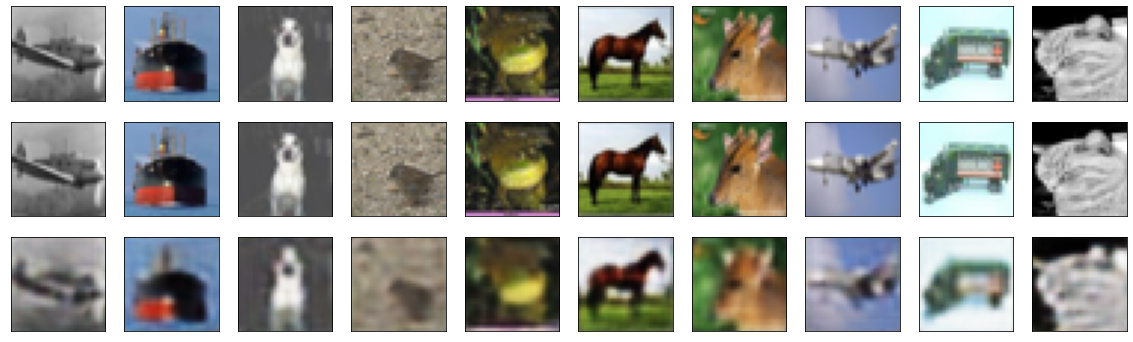

In [15]:
c10test = autoencoder.predict(x_test)
showOrigDec(x_test, x_test, c10test)


In [16]:
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense


In [88]:
class Classifier(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same')
        self.BN1 = BatchNormalization()
        self.relu = Activation('relu')
        self.maxpool = MaxPooling2D((2, 2), padding='same')
        self.conv2 = Conv2D(32, (3, 3), padding='same')
        self.BN2 = BatchNormalization()
        self.linear = Dense(10, activation='softmax')
        self.flatten = Flatten()
        self.dropout = Dropout(0.5)
        
    def encode(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
        
    def call(self, inputs):
#         print(inputs)
        x = autoencoder.encode(inputs)
#         print(x.shape)
        x = self.conv1(x)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
#         print(x.shape)
#         input()
        return x
      
classifier = Classifier()
# classifier.build((None, 32, 32, 3))
# classifier.summary()
# classifier.compile(optimizer='adam', loss='categorical_crossentropy')

In [89]:
import tensorflow_addons as tfa
# loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tfa.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-4)
classifier.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [90]:
checkpoint = ModelCheckpoint(filepath='./classifier', 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=0.5, 
                                   patience=5, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=20)
callbacks_list = [checkpoint, reduceLROnPlat, early]

In [91]:
AUTO = tf.data.AUTOTUNE
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 10)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 10)
    .batch(BATCH_SIZE)
)

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

# First create the new dataset using our `mix_up` utility
batched_dataset = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

In [92]:
# batched_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
batched_val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [93]:
start = datetime.datetime.now()
history = classifier.fit(x=batched_dataset, 
                    validation_data=batched_val_dataset, 
                    epochs=100,
                    callbacks=callbacks_list,
                    verbose=1)
end = datetime.datetime.now()
CNN_time = end - start

Epoch 1/100
313/313 [==============================] - 3s 7ms/step - loss: 2.1826 - acc: 0.2011 - val_loss: 1.9952 - val_acc: 0.2924

Epoch 00001: val_acc improved from -inf to 0.29240, saving model to .\classifier
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 1.9761 - acc: 0.3160 - val_loss: 1.8453 - val_acc: 0.3377

Epoch 00002: val_acc improved from 0.29240 to 0.33770, saving model to .\classifier
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 1.7930 - acc: 0.3991 - val_loss: 1.8054 - val_acc: 0.3454

Epoch 00003: val_acc improved from 0.33770 to 0.34540, saving model to .\classifier
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 1.6625 - acc: 0.4612 - val_loss: 1.8419 - val_acc: 0.3252

Epoch 00004: val_acc did not improve from 0.34540
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 1.5742 - acc: 0.5037 - val_loss: 1.8086 - val_acc: 0.3445

Epoch 00005: val_acc did not im